### This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 



The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions. Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. This is a mini-project to complete as a weekly assignment, so we don't expect you to iterate over your project until you have a model capable of winning the challenge. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project, E.g., a model score above 0.00000.  

Load data 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
# pd display setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 2000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)


#load data
train_path ="./Datasets/train.csv"
test_path="./Datasets/test.csv"
train_data = pd.read_csv(train_path)
test_data =pd.read_csv(test_path)

print('实验数据大小:',train_data.shape)
print('预测数据大小:',test_data.shape)

实验数据大小: (7613, 5)
预测数据大小: (3263, 4)


### Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

In [2]:
print(train_data.info())
print(train_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
         id keyword location                                               text  target
0         1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
1         4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1
2         5     NaN      NaN  All residents asked to 'shelter in place' are ...       1
3         6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1
4         7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1
...     ...     ...      ...               

In [3]:
print(test_data.info())
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
print(train_data['location'].isnull().sum())
print(train_data['keyword'].isnull().sum())


2533
61


特征是keyword、location、text，只有loction有大量缺失数据

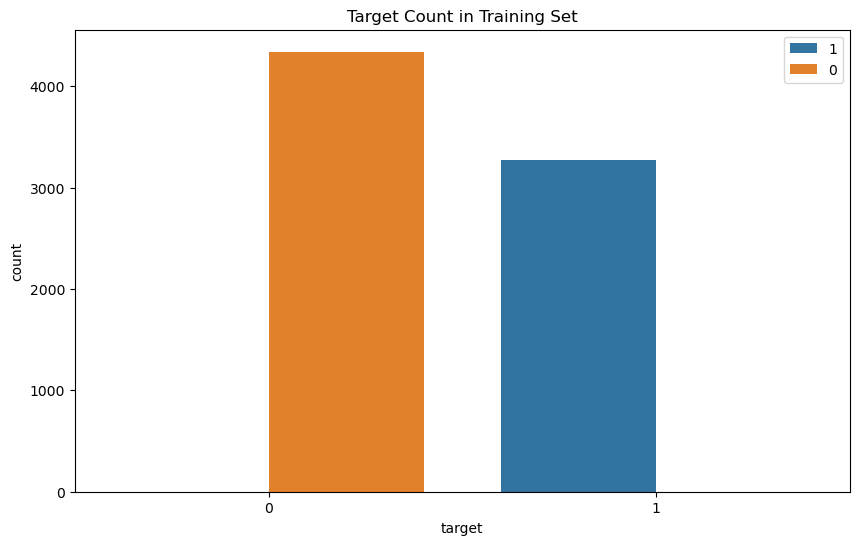

In [5]:
fig = plt.figure(figsize=(10,6))
plt.tight_layout()

train_data.groupby('target').count()['id']
sns.countplot(x=train_data['target'], hue=train_data['target'].astype(str))
plt.legend(loc=0)
plt.title('Target Count in Training Set')

plt.show()


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [6]:
# keyword location text  ---target


loc_tar1=train_data[train_data['target'] == 1]['location']
print(len(loc_tar1.unique())/len(loc_tar1))

loc_tar0=train_data[train_data['target'] == 0]['location']
print(len(loc_tar0.unique())/len(loc_tar0))

loc_count_tar1 = loc_tar1.value_counts()
loc_count_tar0 = loc_tar0.value_counts()

count= 5

print(loc_count_tar1[loc_count_tar1>count].info(),'\n')
print(loc_count_tar0[loc_count_tar0>count].info(),'\n')

common_locs = set(loc_count_tar1[loc_count_tar1>count].index).intersection(set(loc_count_tar0[loc_count_tar0>count].index))
#输出共有键的数量
print("Number of common loc:", len(common_locs))

0.4628553959033935
0.4935513588208199
<class 'pandas.core.series.Series'>
Index: 30 entries, USA to Ireland
Series name: count
Non-Null Count  Dtype
--------------  -----
30 non-null     int64
dtypes: int64(1)
memory usage: 480.0+ bytes
None 

<class 'pandas.core.series.Series'>
Index: 35 entries, New York to Dallas, TX
Series name: count
Non-Null Count  Dtype
--------------  -----
35 non-null     int64
dtypes: int64(1)
memory usage: 560.0+ bytes
None 

Number of common loc: 18


unique的数量占比高达0.5，说明数据集具有相当的多样性，每个实例都有其独特的特征。通过对比正负数据，正负数据有18组数据重复，占比约2/3，灾难评论和位置不太相关

In [7]:
key_tar1=train_data[train_data['target'] == 1]['keyword']
print(len(key_tar1.unique())/len(key_tar1))

key_tar0=train_data[train_data['target'] == 0]['keyword']
print(len(key_tar0.unique())/len(key_tar0))

key_count_tar1 = key_tar1.value_counts()
key_count_tar0 = key_tar0.value_counts()

print(key_count_tar1.head(100) ,'\n')
print(key_count_tar0.head(100),'\n')

# 转换索引为集合并求交集


common_keys = set(key_count_tar1[key_count_tar1>20].index).intersection(set(key_count_tar0[key_count_tar0>20].index))
# 输出共有键的数量
print("Number of common keys:", len(common_keys))






0.06756343625802506
0.05043758636573008
keyword
derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
disaster       15
casualty       15
hostage        15
bomb           15
collapse       15
Name: count, Length: 100, dtype: int64 

keyword
body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
dead                 23
emergency            23
nuclear%20reactor    22
collapsed            22
damage               22
Name: count, Length: 100, dtype: int64 

Number of common keys: 0


* 与location相比，keyword的多样性较低，这可能使得关键词与目标类别之间的关联性更容易被检测到。
* keyword的正负数据各类型数量比较均衡，这通常有利于检测特征与目标之间的关系
* 正负数据的keyword没有明显的相同项

In [8]:
key_train=train_data['keyword'].value_counts()
print(key_train.shape)
key_test =test_data['keyword'].value_counts()
print(key_test.shape)
common_keys = set(key_train[key_train>0].index).intersection(set(key_test[key_test>0].index))
# 输出共有键的数量
print("The number of keywords common to the training and test data:", len(common_keys))

(221,)
(221,)
The number of keywords common to the training and test data: 221


训练集和测试集的keyword完全重复，说明训练集的keyword可以用在测试集上


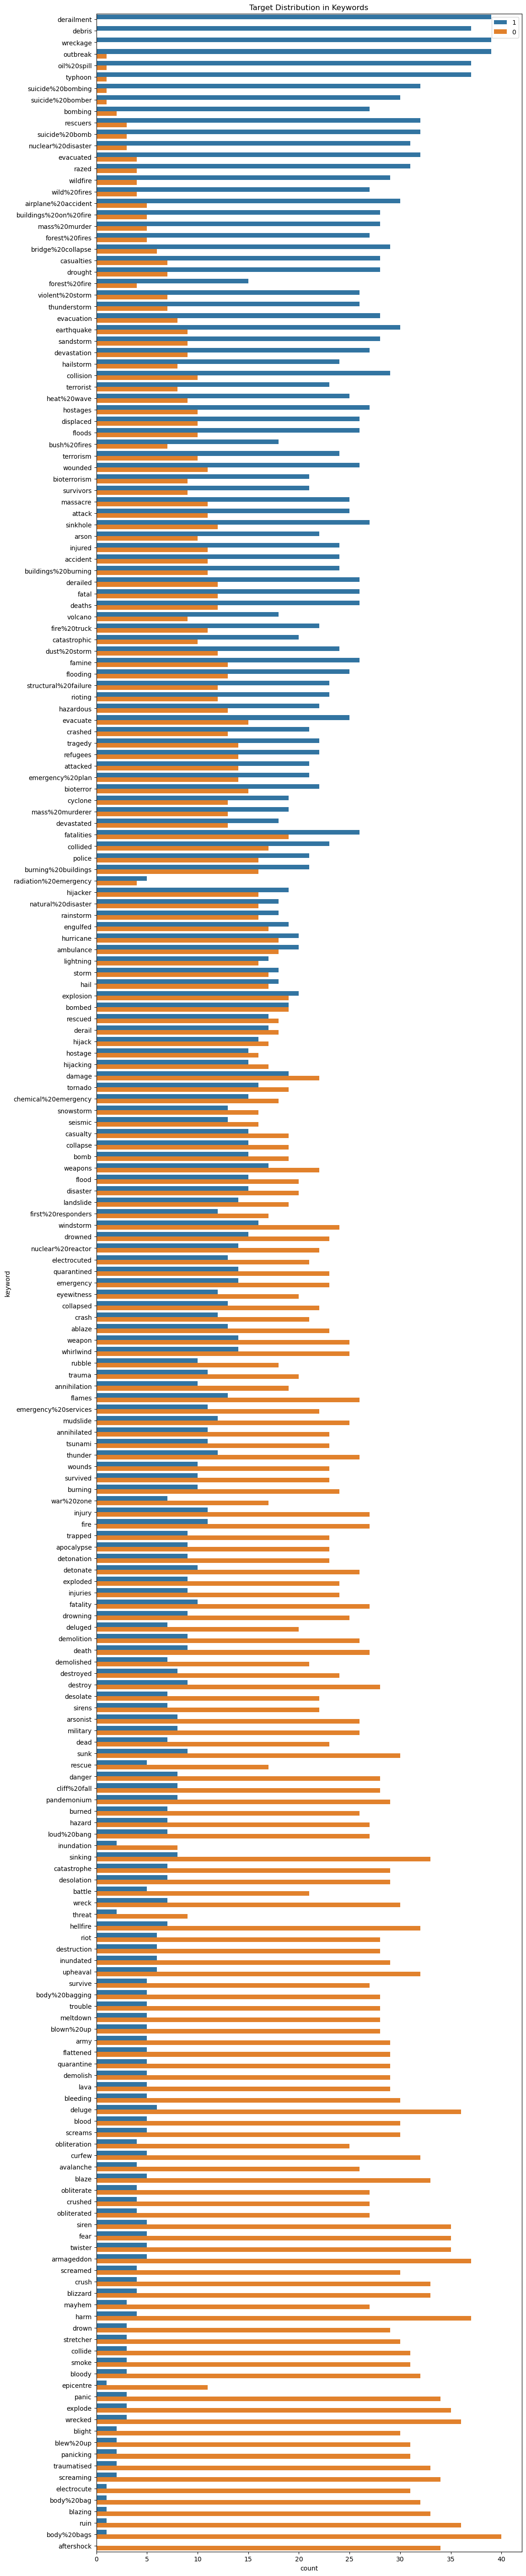

In [9]:
# 以keyword来分组抽取target的平均值
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(12,72))
sorted_data = train_data.sort_values(by='target_mean', ascending=False)
# 绘制图形，根据关键字keyword，并且根据target_mean降序排列
sns.countplot(y=sorted_data['keyword'], hue=sorted_data['target'].astype(str))

plt.legend(loc=0)
plt.title('Target Distribution in Keywords')

plt.show()

# 删除掉列
train_data.drop(columns=['target_mean'], inplace=True)


有些词只在灾难推文中出现，而有些词只在非灾难推文中出现。说明keyword是可用字段

In [4]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# methods for cleaning the text column
def convert_to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub(f'[{string.punctuation}]', '', text) #移除文本中的所有标点符号
    return text

def remove_numbers(text):
    text = re.sub(r'\d+', '', text) #移除文本中的所有数字。
    return text

#将文本分词，然后去除长度小于等于2的单词和停用词。
def remove_short_words_and_stop_words(text):
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

def remove_multiple_spaces(text):
    cleaned_text = re.sub(r' {2,}', ' ', text) #连续的两个或更多空格替换为单个空格。
    return cleaned_text

def clear_text(df, col):
    df[col] = df[col].apply(convert_to_lowercase)
    df[col] = df[col].apply(remove_punctuation)
    df[col] = df[col].apply(remove_numbers)
    df[col] = df[col].apply(remove_short_words_and_stop_words)
    df[col] = df[col].apply(remove_multiple_spaces)
    return df

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [5]:
train_data = train_data.fillna('UNK')
test_data  = test_data.fillna('UNK')
# concat train and test data
full_data = pd.concat([train_data,test_data],ignore_index=True)
full_data =full_data.drop('location',axis=1)
print(full_data['text'].head())
#clear text
full_data = clear_text(full_data,'text')

print(full_data['text'].head()) #Check if clear succeeds
print(full_data.shape)  # full_data.shape[1]==3

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0            deeds reason earthquake may allah forgive
1                   forest fire near ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object
(10876, 4)


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer


#对文本特征进行编码
ohe =OneHotEncoder(handle_unknown='ignore')
kw_X_train =ohe.fit_transform(train_data[['keyword']].values).todense()
kw_X_test =ohe.transform(test_data[['keyword']].values).todense()
kw_X_train.shape




# vec = CountVectorizer(lowercase=True,stop_words='english')
# kw_X_train =vec.fit_transform( train_data['keyword'].values).todense()
# kw_X_test =vec.transform(test_data['keyword'].values).todense()
# kw_X_train.shape

(7613, 222)

考虑 tweet 的特点（短文本、非正式语言、表情符号等）

(10913,)


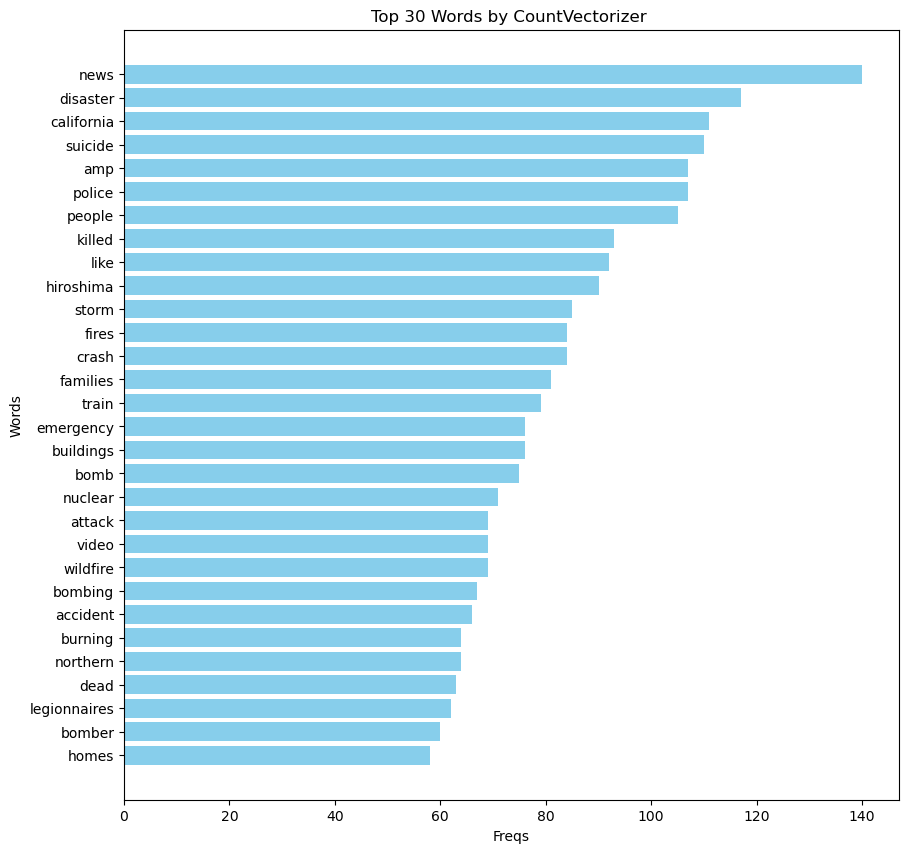

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

#对文本特征进行编码

vec = CountVectorizer(lowercase=True,stop_words='english')
texts_with_target_1 = full_data[full_data['target'] == 1]['text']

text_X_cv = vec.fit_transform(texts_with_target_1)

vocab = vec.get_feature_names_out()

freqs = text_X_cv.sum(axis=0).tolist()[0]
feature_names = vec.get_feature_names_out()
print(feature_names.shape)
freqs_data = pd.DataFrame({
    'word': feature_names,
    'freqs': freqs
})
# The top N terms with the highest TF-IDF value are selected
top_n = 30
top_n_freqs = freqs_data.sort_values(by='freqs', ascending=False).head(top_n)


plt.figure(figsize=(10, 10))
plt.barh(top_n_freqs['word'], top_n_freqs['freqs'], color='skyblue')
plt.xlabel('Freqs')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by CountVectorizer ')
plt.gca().invert_yaxis()
plt.show()


feature sizs: 11078
(11078,)
(11078,)


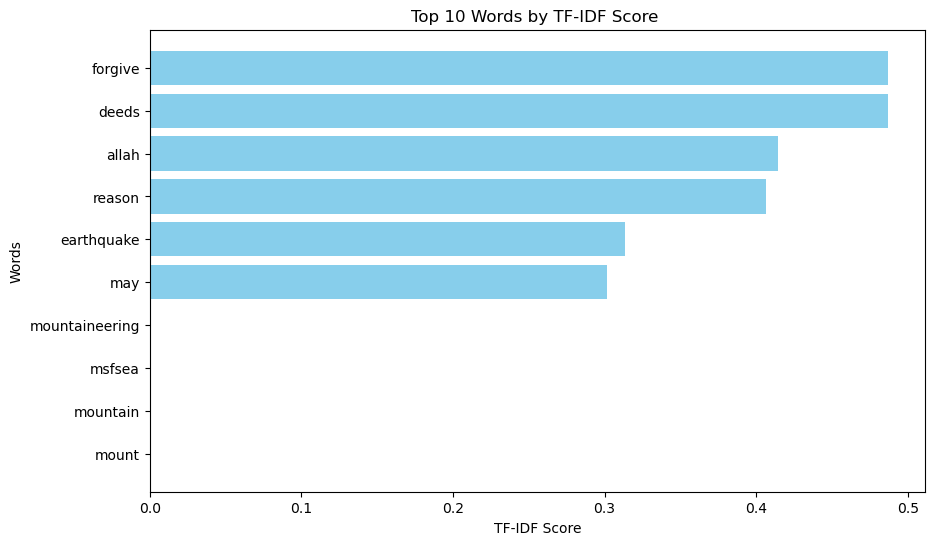

pandas.core.frame.DataFrame

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vec  = TfidfVectorizer() #A measure of how important a word is in a document or corpus

#The text data in full_data was fitted and transformed using tfidf_vec to generate the TF-IDF feature matrix full_tfidf
texts_with_target_1 = full_data[full_data['target'] == 1]['text']
text_X_tfidf  = tfidf_vec.fit_transform(texts_with_target_1)

print('feature sizs:',text_X_tfidf.shape[1]) #Shows how many features the text has been converted into




feature_names = tfidf_vec.get_feature_names_out()
print(feature_names.shape)
tfidf_scores = text_X_tfidf[0].toarray().flatten()
print(tfidf_scores.shape)
tfidf_data = pd.DataFrame({
    'word': feature_names,
    'tfidf': tfidf_scores
})


# The top N terms with the highest TF-IDF value are selected
top_n = 10
top_n_tfidf = tfidf_data.sort_values(by='tfidf', ascending=False).head(top_n)



plt.figure(figsize=(10, 6))
plt.barh(top_n_tfidf['word'], top_n_tfidf['tfidf'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by TF-IDF Score ')
plt.gca().invert_yaxis()
plt.show()
type(top_n_tfidf)


In [8]:
def text2vec(type,data):
    vec=None
    if type=='CountVectorizer':
        vec = CountVectorizer(lowercase=True,stop_words='english')
        pass
    elif type=='TfidfVectorizer':
        vec  = TfidfVectorizer(lowercase=True,stop_words='english')
        pass
    else :
        pass
    if vec is not None:
        text_X = vec.fit_transform(data)
        print(text_X.shape)
        return text_X.todense()
        
    return None

In [9]:
import torch
from sklearn.model_selection import train_test_split
text_X_train= text2vec('CountVectorizer', full_data[full_data['target'].notnull()]['text'])
text_X_test= text2vec('CountVectorizer', full_data[full_data['target'].isnull()]['text'])
X_train =np.concatenate([kw_X_train,text_X_train],axis=1)
X_test =np.concatenate([kw_X_test,text_X_test],axis=1)

X_train =np.asarray(X_train)
X_test =np.asarray(X_test)
y_train =np.asarray(full_data[full_data['target'].notnull()]['target']) 


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, stratify = y_train)
# print(type(y_train),type(y_valid))
# X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
# X_valid, y_valid = torch.Tensor(X_valid), torch.Tensor(y_valid)
print(X_train.shape)
print(X_valid.shape)


(7613, 20982)
(3263, 11680)
(6090, 21204)
(1523, 21204)


In [10]:
import tensorflow as tf
# Optional: Restrict TensorFlow to only use the first GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) >0:
    print(physical_devices)
    try:
    
        tf.config.set_visible_devices(devices=physical_devices[0], device_type='GPU')
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    
logical_devices = tf.config.list_logical_devices('GPU')
print(f"Physical GPUs: {len(physical_devices)}, Logical GPUs: {len(logical_devices)}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical GPUs: 1, Logical GPUs: 1


In [11]:


from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping

#declare metrics for analysis during training
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
MAX_FEATURES =3000
embed_dim = 32 #The output_dim in the Embedding layer refers to the size of the dense vector space in which words will be embedded, not directly to the classification output. 
lstm_out = 32
# first model - LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=MAX_FEATURES,
                         output_dim=embed_dim,  
                         input_length=X_train.shape[1]))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(LSTM(lstm_out, 
                    dropout=0.1, 
                    recurrent_dropout=0.25))
model_LSTM.add(Dense(1, 
                     activation='sigmoid'))
adam_optimizer = optimizers.Adam(learning_rate=0.0001)
model_LSTM.compile(loss='binary_crossentropy', 
                   optimizer=adam_optimizer, 
                   metrics=['accuracy', recall, precision])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21204, 22)         66000     
                                                                 
 dropout (Dropout)           (None, 21204, 22)         0         
                                                                 
 lstm (LSTM)                 (None, 22)                3960      
                                                                 
 dense (Dense)               (None, 1)                 23        
                                                                 
Total params: 69,983
Trainable params: 69,983
Non-trainable params: 0
_________________________________________________________________


In [12]:
BATCH_SIZE = 32
EPOCHS = 8

# history
LSTM_history = model_LSTM.fit(X_train, 
                              y_train, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid, y_valid))

Epoch 1/8


KeyboardInterrupt: 

### Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [ ]:

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:




class LSTM(nn.Module):
    def __init__(self,no_layers, vocab_size, hidden_dim, embedding_dim, output_dim):
        super().__init__()

        self.no_layers = no_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=no_layers,
            batch_first=True,
        )

        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layers with BatchNorm and Dropout
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)  # Reduce size to decrease complexity
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # BatchNorm
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Further reduction
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)  # Final output layer

    def forward(self, x,h):
       # Embedding and LSTM
        x = self.embedding(x)
        x, hidden = self.lstm(x, h)
        x = x[:, -1, :]  # Use last output for classification
        x = self.dropout(x)  # Apply dropout

        # Fully Connected Layers with ReLU, BatchNorm, and Dropout
        x = nn.functional.relu(self.fc1(x))
        x = self.bn1(x)  # Apply batch normalization
        x = nn.functional.dropout(x, 0.5)  # Apply dropout
        
        x = nn.functional.relu(self.fc2(x))
        x = self.bn2(x)
        x = nn.functional.dropout(x, 0.5)  # Additional dropout for regularization
        
        return self.output(x), hidden  # Output layer
    
    def init_hidden(self, batch_size):
         # Initialize hidden states
         h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
         c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
         hidden = (h0, c0)
         return hidden
    


    # Create the model with modified layer dimensions
lstm = LSTM(
    no_layers=3,
    hidden_dim=256,
    output_dim=1,
    embedding_dim=128,
    vocab_size=len(vocab) + 1,
)
# Loss function and optimizer with L2 regularization
lossfun = nn.BCEWithLogitsLoss()  # Binary classification
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0001, weight_decay=0.01)  # L2 regularization


In [ ]:

clip = 5
 
torch.manual_seed(1)
# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 8

INPUT_SIZE = 28     # rnn 每步输入值 / 图片每行像素
LR = 0.01           # learning rate
HIDDEN_SIZE =64
HIDDEN_LAYERS =1

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

valid_dataset = TensorDataset(X_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
lstm.to(device)
trainAcc = []
trainLoss = []
devAcc = []
devLoss = []

yTrue, yPred = [], []

for epochi in range(EPOCH):
    batchAcc = []
    batchLoss = []
    
    h = lstm.init_hidden(BATCH_SIZE)
    
    lstm.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device, dtype=torch.int), y.to(device)
        h = tuple([each.data for each in h])
        yHat, h = lstm.forward(X,h)
        yHat = yHat.squeeze()
        loss = lossfun(yHat, y)
        
        batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
        batchLoss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        nn.utils.clip_grad_norm_(lstm.parameters(), clip)
        optimizer.step()
    
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    lstm.eval()
    
    with torch.no_grad():
        
        h = lstm.init_hidden(BATCH_SIZE)
    
        batchAcc = []
        batchLoss = []
        for X, y in valid_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            h = tuple([each.data for each in h])
            yHat, h = lstm.forward(X,h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            
            yPred.extend(yHat.cpu() > .0)
            yTrue.extend(y.cpu())
            batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
            batchLoss.append(loss.item())
        devAcc.append(np.mean(batchAcc))
        devLoss.append(np.mean(batchLoss))
        


RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# # 在训练过程中，在某个时刻保存状态
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': epoch,
#     'loss': loss,
# }, 'checkpoint.tar')
 
# # 之后，可以恢复模型和优化器
# checkpoint = torch.load('checkpoint.tar')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
 

### Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:
def save_data(y_pred,filename):
    submission=pd.DataFrame ( {
    "id" : test_data [ "id" ],
    "target" : y_pred.astype (int)
    })
    submission.to_csv ( filename+'_result.csv',index=False)

### Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

### Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (30 points)
These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.

For the sake of this project, you can use GitHub to showcase your codebase. In the real world, versioning with GitHub is vital for collaboration. Sometimes Jupyter notebooks don’t seem particularly well-suited to versioning with GitHub due to hard-to-read diffs and the like. If you want to use this project as an opportunity to practice versioning with GitHub, consider something like the following: 
https://www.reviewnb.com
.